# Module 12 Lab - Distance Based Machine Learning

## Directions

1. Show all work/steps/calculations. Generate a Markdown/code cells for each answer.
2. You must submit your lab by the deadline to the Lab section of the Course Module where you downloaded this file from.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

We're getting to the point in the semester where you should be know the drill.

This module covered 3 basic problems: supervised learning (classification, regression), unsupervised learning (clustering) and recommenders (collaborative filtering based systems related to missing value imputation) using distance/similarity. We're only going to cover the first 2 in this lab.

You should definitely use [Scikit Learn](http://scikit-learn.org/stable/) and refer to the documentation for this assignment.

Remember to create a new random seed for each experiment (if needed) and save it.

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.neighbors as neighbors
import sklearn.linear_model as linear
import models

sns.set(style="whitegrid")

**Problem 1. kNN Regression**

Use k-Nearest Neighbors *regression* for the insurance data set. Make sure you do the following:

1. Pick an appropriate evaluation metric.
2. Validation curves to find the best value of k.
3. Learning curves to see if we are high bias or high variance and suggest ways to improve the model.
4. 10 fold cross validation to estimate the mean metric and its credible interval.
5. Was this better than the best linear regression model you estimated in Lab 11? Use Bayesian statistical inference to generate and evaluate the posterior distribution of the difference of means.

We start by loading the data.

In [4]:
insurance = pd.read_csv("https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/insurance.csv", header=0)

### Linear Regression Model

We're going to reverse the order a bit and complete the cross-validation of our linear regression model from the last Lab:

In [5]:
insurance = pd.concat([insurance, pd.get_dummies(insurance["sex"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["region"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["smoker"], prefix="smoke")], axis=1)
insurance["age_sq"] = insurance.age**2
insurance["bmi_above_30"] = insurance.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)

In [7]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + bmi_above_30 + smoke_yes:bmi_above_30 + children + male:children"
result = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,2127.75,951.99,3754.96
age_sq,$\beta_{1}$,-424.64,-869.50,261.79
male,$\beta_{2}$,1440.54,-1903.58,5952.95
bmi,$\beta_{3}$,3.34,3.11,3.57
smoke_yes,$\beta_{4}$,-3.29,-67.82,39.91
smoke_yes:bmi,$\beta_{5}$,472.67,319.16,598.41
bmi_above_30,$\beta_{6}$,100.41,-621.16,976.18
smoke_yes:bmi_above_30,$\beta_{7}$,15111.55,13632.36,16826.01
children,$\beta_{8}$,695.50,448.66,1013.40


In [8]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

Let's do our 3 rounds of 10 fold cross validation:

In [9]:
formula = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
lr_result = cross_validation(models.linear_regression, formula, insurance, lambda r: (r["sigma"], r["r_squared"]))

### Evaluation Metric

MSE can be difficult to interpret although it is definitely something you need to take in account when building regression models. Not all models with the same $R^2$ will have the same MSE. The latter is model dependent. Still we're look at $R^2$. Another thing to remember as we get into validation curves, is that,  unlike MSE, bigger $R^2$ is better.

In [10]:
print(r"95% CI for R^2:", stats.mstats.mquantiles([r[1] for r in lr_result], [0.025, 0.975]))

95% CI for R^2: [0.7722714 0.9529842]


## k Nearest Neighbors

This is what we want to beat with our kNN model. First, we need to *scale* all of our numeric variables which are `bmi` and `age`. k Nearest Neighbors is very sensitive to differences in magnitude, perhaps even more than linear regression.

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()

In [13]:
columns = ["bmi", "age"]
insurance[columns] = scaler.fit_transform(insurance[columns])

Here is a special function for cross validation for kNN:

In [14]:
def dmatrix_to_array(dmatrix):
    return np.array([row[0] for row in dmatrix])

In [15]:
def knn_cross_validation(formula, builder, data, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = {"train": [], "test": []}
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            # y, X for training data
            y, X = patsy.dmatrices(formula, train_data, return_type="matrix")
            model = builder.fit(X, y)
            y_hat = model.predict(X)
            training_r_squared = (stats.pearsonr(dmatrix_to_array(y), dmatrix_to_array(y_hat))[0])**2
            metrics["train"].append(training_r_squared)
            # y, X for test data
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            ys = [el[0] for el in y]
            y_hat = model.predict(X)
            test_r_squared = (stats.pearsonr(dmatrix_to_array(y), dmatrix_to_array(y_hat))[0])**2
            metrics["test"].append(test_r_squared)
    return metrics

### Finding the best k using Validation Curves

We're going to try a vanilla "all in" model with kNN without any transformations. kNN doesn't use the values of $X$ to estimate $y$...the estimate of $y$ comes directly from the data points. This means that transformations on $X$ aren't quite as important.

Our first goal is to find the best k for our kNN model using validation curves:

In [16]:
formula = "charges ~ 0 + bmi + age + male + smoke_yes + children"

In [17]:
test_curve = []
train_curve = []
for k in range(1, 21):
    builder = neighbors.KNeighborsRegressor(k)
    results = knn_cross_validation(formula, builder, insurance)
    test_curve.append(stats.mstats.mquantiles(results['test'], [0.025, 0.5, 0.975]))
    train_curve.append(stats.mstats.mquantiles(results['train'], [0.025, 0.5, 0.975]))
    

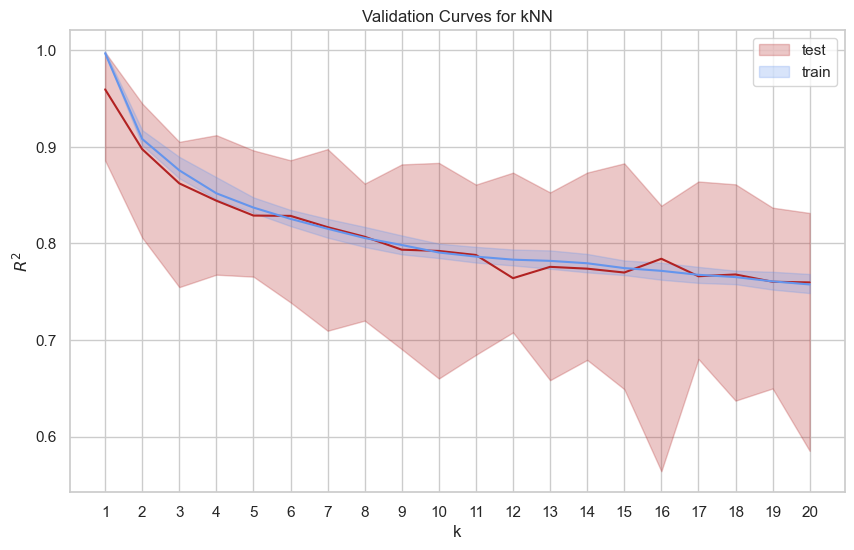

In [18]:
xs = list(range(1, 21))
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.
axes = figure.add_subplot(1, 1, 1)

test_lower, test_mid, test_upper = zip(*test_curve)
train_lower, train_mid, train_upper = zip(*train_curve)

axes.fill_between(xs, test_lower, test_upper, alpha=0.25, color="firebrick", label="test")
axes.plot(xs, test_mid, color="firebrick")

axes.fill_between(xs, train_lower, train_upper, alpha=0.25, color="cornflowerblue", label="train")
axes.plot(xs, train_mid, color="cornflowerblue")

axes.set_xticks(xs)
axes.set_xticklabels([str(x) for x in xs])

axes.legend()
axes.set_title("Validation Curves for kNN")
axes.set_xlabel("k")
axes.set_ylabel("$R^2$")

plt.show()
plt.close()

It appears that k=1 is the best value for *this* model (You may have gotten a different result if you use different variables or did not mean scale `age` and `bmi`).

[Notice that I changed the title and axis labels on the chart]

## Learning Curves

The next step is to plot learning curves to see if and how we can improve the model.

In [16]:
from collections import defaultdict

In [17]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [18]:
def knn_learning_curves(builder, formula, data, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                y, X = patsy.dmatrices(formula, train_data_chunk, return_type="matrix")
                model = builder.fit(X, y)
                y_hat = model.predict(X)
                training_r_squared = (stats.pearsonr(dmatrix_to_array(y), dmatrix_to_array(y_hat))[0])**2
                results["train"][i].append(training_r_squared)
                
                # y, X for test data
                y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
                y_hat = model.predict(X)
                test_r_squared = (stats.pearsonr(dmatrix_to_array(y), dmatrix_to_array(y_hat))[0])**2
                results["test"][i].append(test_r_squared)
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

In [19]:
result = knn_learning_curves(neighbors.KNeighborsRegressor(1), formula, insurance)

In [20]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [21]:
def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()

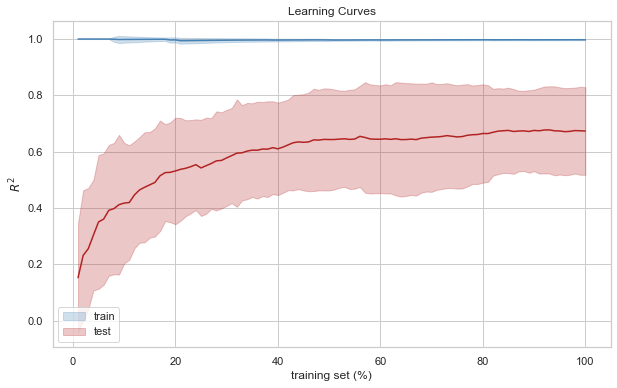

In [22]:
plot_learning_curves(result, "$R^2$")

The unfortunate part of k=1 is that the "train" curve is a bit weird, in fact, it suggests we're overfitting our data. The test curve has converged.

(Again, you may have gotten different results, depending. One thing I have noticed is students saying that the curves have not curved even though their confidence/credible intervals overlap. This is a bit weird...statistically, we cannot say they haven't converged if their confidence/credible intervals overlap]

## Cross Validation

In order to get a sense of the generalization error of our final model, we will perform 3 x 10 fold cross validation and look at the credible interval from the posterior distribution of $R^2$:

In [23]:
builder = neighbors.KNeighborsRegressor(1)
knn_results = knn_cross_validation(formula, builder, insurance)

In [24]:
print(r"95% CI for R^2:", stats.mstats.mquantiles(knn_results['test'], [0.025, 0.975]))

95% CI for R^2: [0.82625814 0.99985938]


Our 95% credible interval for the posterior distribution of $R^2$ is 84.3 to 99.9. This is a little off from our estimate using the mean and standard deviation when we built our learning curves.

## Model Comparison

We have 30 $R^2$ estimates for both the linear regression and the kNN models for this problem. With that data, we can do separate bootstrap estimates of the posterior distributions of the *mean* $R^2$ of the models and the differences in the models.

In [25]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [26]:
knn_bootstrap = bootstrap_sample(knn_results['test'], np.mean)
lr_bootstrap = bootstrap_sample([r[1] for r in lr_result], np.mean)
difference = knn_bootstrap - lr_bootstrap

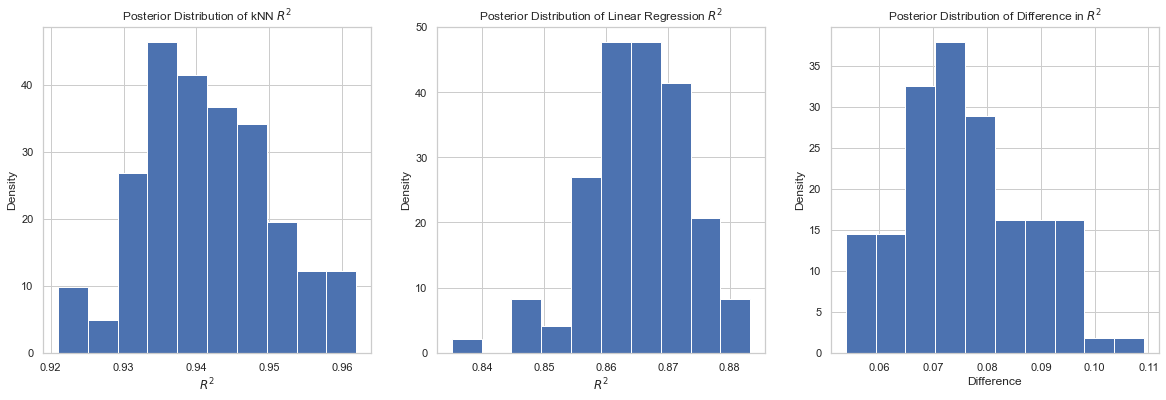

In [27]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(knn_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of kNN $R^2$")

axes = figure.add_subplot(1, 3, 2)

axes.hist(lr_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Linear Regression $R^2$")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in $R^2$")

plt.show()
plt.close()

In [28]:
print("P(kNN > LR)", np.mean(difference > 0))

P(kNN > LR) 1.0


This is basically a difference of means test. Here we can see that there is little evidence that that linear regression is better than kNN. Of course, we cannot really rule out that the linear regression is better but the evidence doesn't support that claim very well.

(again, you may get different results depending on your linear regression and kNN results; notice that the chart labels are changed.)